In [ ]:
!pip install nbimporter

In [1]:
import numpy as np
import tensorflow as tf
from time import time
import sys
from dataLoader import loadData
import os

In [2]:
# # Downloading Movielens-1m
# !curl -O http://files.grouplens.org/datasets/movielens/ml-1m.zip
# #     http://www.grouplens.org/system/files/ml-1m.zip
# !unzip ml-1m.zip
# !cd ml-1m/

In [3]:
# import zipfile
# with zipfile.ZipFile('ml-1m.zip', 'r') as zip_ref:
#     zip_ref.extractall('./')

In [4]:
seed = 47
np.random.seed(seed)

In [5]:
# load data
tr, vr = loadData('./ml-1m/ratings.dat', delimiter='::', seed=seed, transpose=False, valfrac=0.1)

reading data...
data read in 5.703738212585449 seconds
loaded dense data matrix


In [6]:
np.save('./tr_movielens_1m', tr)
np.save('./vr_movielens_1m', vr)

In [7]:
tr

array([[5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [3., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [8]:
vr

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [9]:
def get_sparsity(mat):
    sparsity = float(len(mat.nonzero()[0]))
    sparsity /= (mat.shape[0] * mat.shape[1])
    sparsity *= 100
    return sparsity

In [10]:
get_sparsity(tr)

4.021525859265269

In [11]:
get_sparsity(vr)

0.44683670296601535

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import torch.nn.init as init
from os.path import isfile, isdir, join
import os

In [13]:
lrD = 5e-4
lrG = 5e-4
batch_size = 64
cuda = True
epochs = 0 #change
nz = 10
d_iter = 5
g_iter = 1
lamba = 1e-3 # constant for L2 penalty (diversity)

In [14]:
train = tr.copy()

In [15]:
if torch.cuda.is_available()==True:
    device="cuda"
else:
    device ="cpu"

In [16]:
features_length = train.shape[1]
class NetD(torch.nn.Module):
    def __init__(self, use_cuda=True):
        super(NetD, self).__init__()
        self.use_cuda = use_cuda
        # top
        self.t1 = torch.nn.Linear(features_length, 1024)
        # bottom
        self.b1 = torch.nn.Linear(features_length, 1024)
        # combined
        self.fc = torch.nn.Linear(2 * 1024, features_length)
    def forward(self, xr, xf):
        # get filt
#         filt = (torch.abs((real > 0.3).float() * fake - real))/real.shape[0]
        filt = torch.abs((real != 0).float().cuda() * fake.cuda() - real.cuda())/(fake == 0).sum()
#         filt = torch.abs((real != 0).float().cuda() * fake.cuda() - real.cuda())

#         filt = torch.abs((xr != 0).int() * xf - xr)
#         filt = 1 - (xr * (xf >= 0.5).float()) - ((1-xr) * (xf < 0.5).float())
        # random swap
        idr = torch.multinomial(torch.Tensor([0.5,0.5]), xr.size(0), replacement=True)
        idrx = idr.float().unsqueeze(1).expand_as(xr)
        if self.use_cuda: 
            idrx = idrx.cuda()
        idrx = Variable(idrx)
        xt = xr * idrx + xf * (1 - idrx)
        xb = xr * (1 - idrx) + xf * idrx
        # top : real
        xt = F.relu(self.t1(xt))
        # bottom : fake
        xb = F.relu(self.b1(xb))
        # combined
        x = torch.cat((xt, xb), 1)
        x = torch.tanh(self.fc(x))
        # apply filter, aggregate
#         print(filt.type(), x.type())
        x = filt * x

        x = x.mean(dim = 1).squeeze()
        # use sign, because of swapping
        sgn = idr * 2 - 1
        if self.use_cuda: 
            sgn = sgn.cuda()
        sgn = Variable(sgn.float())
        x = sgn * x
        return x
        
# netG = torch.nn.Sequential(
#     torch.nn.Linear(nz, 1024),
#     torch.nn.ReLU(),
#     torch.nn.Linear(1024, features_length),
#     torch.nn.Sigmoid()*5
#     )

class NetG(nn.Module):
    
    def __init__(self):

        super(NetG, self).__init__()

        self.net = torch.nn.Sequential( 
                                torch.nn.Linear(nz, 1024), 
                                torch.nn.ReLU(), 
                                torch.nn.Linear(1024, 1024), 
                                torch.nn.Sigmoid(), 
                                nn.Dropout(0.5),
                                torch.nn.Linear(1024, features_length), 
                                torch.nn.Sigmoid(), 
                                nn.Dropout(0.6)
                                )

#         self.net = nn.Sequential(
#                                  nn.Linear(nz,1024),
# #                                  nn.Dropout(0.3)
#                                  nn.ReLU(),
#                                  nn.Linear(1024,2048),
#                                  nn.Sigmoid(),
#                                  nn.Dropout(0.3),
#                                  nn.Linear(2048,features_length),
# #                                  nn.Sigmoid()
#                                  nn.Dropout(0.5)
#                                     )
        
    def forward(self, x):
        x = self.net(x)
#         return x
        return x*5 # to get values in range [0,5]
    
# networks
netD = NetD().to(device)
netG = NetG().to(device)
print(netG)
print(netD)
optimizerG = optim.RMSprop(netG.parameters(), lr=lrG)
optimizerD = optim.RMSprop(netD.parameters(), lr=lrD)
one = torch.FloatTensor([1])
mone = one * -1

NetG(
  (net): Sequential(
    (0): Linear(in_features=10, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): Sigmoid()
    (4): Dropout(p=0.5)
    (5): Linear(in_features=1024, out_features=3706, bias=True)
    (6): Sigmoid()
    (7): Dropout(p=0.6)
  )
)
NetD(
  (t1): Linear(in_features=3706, out_features=1024, bias=True)
  (b1): Linear(in_features=3706, out_features=1024, bias=True)
  (fc): Linear(in_features=2048, out_features=3706, bias=True)
)


In [17]:
one = torch.FloatTensor([1]).to(device)
mone = (one * -1).to(device)

In [18]:
for p in netD.parameters(): # reset requires_grad
    p.requires_grad = True #
    
for p in netG.parameters(): # reset requires_grad
    p.requires_grad = True #

In [19]:
def get_random_batch(mat, batch_size=16):
    rand_rows = np.random.randint(mat.shape[0], size=batch_size)
#     print(mat.shape, rand_rows)
#     print(mat[rand_rows].shape)
    return mat[rand_rows]

In [20]:
get_random_batch(train, batch_size=batch_size).shape

(64, 3706)

In [21]:
train = torch.autograd.Variable(torch.Tensor(train))

In [22]:
def d_my(x_r, x_g): # custom loss -todo
    return torch.sum(torch.abs((x_r != 0).float() * x_g - x_r))

In [23]:
steps_per_epoch = 300
gen_iterations = 0
eval_losses = []
for epoch in range(0):
#     data_iter = iter(data_loader)
    i = 0
    while i < steps_per_epoch:
        ############################
        # (1) Update D network
        ###########################
        for p in netD.parameters(): # reset requires_grad
            p.requires_grad = True # they are set to False below in netG update
        d_iter = d_iter
        j = 0
        while j < d_iter*5:
            j += 1
            # load real data
            i += 1
#             X, _ = data_iter.next()
            X = get_random_batch(train, batch_size=batch_size)
#             X += torch.Tensor(np.random.normal(0, 0.2, X.shape))
#             print(X >= 0.5)
# #             X = X.view(X.size(0), -1)
#             X = (X >= 0.5).float()
            if cuda: 
                X = X.cuda()
            real = Variable(X)
            # generate fake data
            noise = torch.randn(batch_size, nz)
            if cuda: 
                noise = noise.cuda()
            with torch.no_grad():
                noisev = Variable(noise) # totally freeze netG
            fake = Variable(netG(noisev).data)
#             print(real[0,:20], fake[0,:20])
            real + fake * (real == 0).float()
            fake = fake * Variable(real != 0).float().cuda()
#             real + fake * (real == 0).float()
#             print(real[0,:20], fake[0,:20])
            fake.requires_grad = False
#             print(real.shape, fake.shape)
    
            # compute gradient, take step
            netD.zero_grad()
#             print('real', real[:10, :20])
#             print('fake', fake[:10, :20])
#             print(real.type(), fake.type())
#             print(fake)
            out = netD(real, fake)
            
            outputD = torch.mean(out) + lamba * out.norm()
            stdD = torch.std(out)
            outputD.backward(mone)
            optimizerD.step()
#             print(out.shape)
        ############################
        # (2) Update G network
        ###########################
        g_iter = g_iter
        j = 0
        while j < g_iter*5:
            j += 1
            for p in netD.parameters():
                p.requires_grad = False # to avoid computation
            netG.zero_grad()
            
            # load real data
            i += 1
            X = get_random_batch(train, batch_size=batch_size)
#             X += torch.Tensor(np.random.normal(0, 0.2, X.shape))
#             X = X.view(X.size(0), -1)
#             X = (X >= 0.5).float()
            if cuda: 
                X = X.cuda()
            real = Variable(X)
            
            # update generator
            noise = torch.randn(batch_size, nz)
            if cuda: 
                noise = noise.cuda()
            noisev = Variable(noise)
            
            fake = netG(noisev)
            real + fake * (real == 0).float()
            fake = fake * Variable(real != 0).float().cuda()
#             fake = fake * Variable(real != 0).float().cuda()
#             fake.requires_grad = False
#             fake = Variable(netG(noisev)).data
#             fake = fake * Variable(((real != 0) & (fake > 0.8))).float().cuda()
#             fake.requires_grad = True
            
            out = netD(real, fake)
            outputG = torch.mean(out) + lamba * out.norm()
            stdG = torch.std(out)
            outputG.backward(one)
            optimizerG.step()

            gen_iterations += 1

#             print('[%d/%d][%d/%d][%d] Loss_D: %f Loss_G: %f '% (epoch, epochs, i, len(data_loader), gen_iterations, outputD.item(), outputG.item()))
#             print('output_D', outputD.item(), gen_iterations)
#             print('output_G', outputG.item(), gen_iterations)
#             print('std_D', stdD.item(), gen_iterations)
#             print('std_G', stdG.item(), gen_iterations)
            torch.save(netG.state_dict(), './netG-1m')
            torch.save(netD.state_dict(), './netD-1m')
            # evaluation
            if gen_iterations % 100 == 0: # todo- to change
#                 gen.eval()
#                 z_vector_eval = make_some_noise(128)
#                 fake_rows_eval = gen(z_vector_eval)
#                 real_rows_eval = get_random_batch(train, 128)
        #         print(fake_rows[0][:10]) enable to see some results
#                 fake = Variable(netG(noisev).data).round()
#                 fake = ((real != 0) & (fake != 0))
#                 print(fake)
                eval_loss = F.mse_loss(fake, real, reduction='mean')
                eval_losses.append(eval_loss)
                print('Epoch number {}. my distance between random real and fake samples {}'.format(epoch, d_my(real, fake)))
                print('Epoch number {}. MSE distance between random real and fake samples {}'.format(epoch, eval_loss))

In [24]:
# torch.save(netG.state_dict(), './netG-1m')
# torch.save(netD.state_dict(), './netD-1m')

In [25]:
import matplotlib.pyplot as plt

plt.plot(eval_losses)
plt.show()

<Figure size 640x480 with 1 Axes>

In [26]:
noise = torch.randn(train.shape[0], nz).to(device)
noisev = Variable(noise)
fake = netG(noisev)

In [27]:
fake.shape

torch.Size([6040, 3706])

In [28]:
fake = np.around(fake.detach().cpu().numpy())

In [29]:
np.unique(fake)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.],
      dtype=float32)

In [30]:
fake = fake * (fake <= 5).astype(int)

In [31]:
print(5, (5 == fake.round()).sum(), (5 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(4, (4 == fake.round()).sum(), (4 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(3, (3 == fake.round()).sum(), (3 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(2, (2 == fake.round()).sum(), (2 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(1, (1 == fake.round()).sum(), (1 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(0, (0 == fake.round()).sum(), (0 == (tr + vr)[:fake.shape[0], :].round()).sum())

5 1751784 226310
4 616209 348971
3 91897 261197
2 3749 107557
1 17 56174
0 19920584 21384031


In [32]:
train > 3 

tensor([[1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8)

In [33]:
get_sparsity(train > 3)

8.934857739195076e-06

In [34]:
(train[0,:] > 3).sum()

tensor(43)

In [35]:
train

tensor([[5., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [3., 0., 0.,  ..., 0., 0., 0.]])

In [36]:
train = torch.Tensor(tr.copy()).to(device)

In [37]:
get_sparsity(train.cpu().numpy())

4.021525859265269

In [38]:
train > 3

tensor([[1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)

In [39]:
zero_mask = (train == 0).to(device).float()

In [40]:
positive_feedback_mask = (train > 3).to(device).float()

In [41]:
negative_feedback_mask = ((train < 4).to(device).float() * (1 - zero_mask)).to(device).float()

In [42]:
((positive_feedback_mask + negative_feedback_mask) != zero_mask).all()

tensor(1, device='cuda:0', dtype=torch.uint8)

In [43]:
get_sparsity(negative_feedback_mask.cpu().numpy())

1.7090908603553212

TRAINING DENOISING AUTOENCODER ON NEGATIVE FEEDBACKS

In [44]:
class denoising_autoencoder(nn.Module):
    def __init__(self, input_size, z=32):
        super(denoising_autoencoder, self).__init__()
        self.encoder=nn.Sequential(
                      nn.Linear(input_size, 1024),
                      nn.ReLU(),
                      nn.Linear(1024,512),
                      nn.ReLU(),
                      nn.Linear(512, z),
#                       nn.Sigmoid()
                      )

        self.decoder=nn.Sequential(
                      nn.Linear(z, 512),
                      nn.ReLU(),
                      nn.Linear(512, 1024),
                      nn.ReLU(),
                      nn.Linear(1024, input_size),
#                       nn.Sigmoid(),
                      )
    
 
    def forward(self, x):
        z = self.encoder(x)
#         print(z.shape)
        x = self.decoder(z)
    
        return x

In [45]:
model = denoising_autoencoder(input_size=train[0,:].shape[0]).to(device)
criterion = nn.L1Loss()
optimizer = optim.RMSprop(model.parameters(),lr=0.0001, weight_decay=1e-3)

In [46]:
# model

In [47]:
def get_random_masked_batch(mat, batch_size = 32, p=0.5):
    '''
    This works as a trainloader for denoising autoencoder.
    Randomly masks observed entries (replaces 1s with 0s) to add a noise
    '''
    rand_rows = np.random.randint(mat.shape[0], size=batch_size)
#     print(rand_rows)
#     return mat[rand_rows], mat[rand_rows]
    orig = mat[rand_rows].clone()
    corrupted = mat[rand_rows].clone()
    mask_arr = torch.FloatTensor((np.random.rand(orig.shape[0], orig.shape[1]) > p)).to(device)

    return orig, corrupted*mask_arr, rand_rows

orig, masked, _ = get_random_masked_batch(negative_feedback_mask)

In [48]:
get_sparsity(orig.cpu().numpy())

2.3585064759848895

In [49]:
get_sparsity(masked.cpu().numpy())

1.1822045331894226

In [50]:
get_sparsity(torch.nn.functional.dropout(masked, training=False).cpu().numpy())

1.1822045331894226

In [51]:
# torch.nn.functional.dropout(orig, training=False)

In [103]:
losslist = []
def train_den_ae(mat,epochs= 400,steps_per_epoch = 300, _unsqueeze=True):
#     epochs = 120
    # l = len(trainloader)
    # l = 120
#     losslist = []
    epochloss = 0
    running_loss = 0
    steps_per_epoch = 100

    for epoch in range(epochs):

        print("Entering Epoch: ", epoch)
        for i in range(steps_per_epoch):
            orig, masked, _ = get_random_masked_batch(mat, batch_size=batch_size)

            #-----------------Forward Pass----------------------
            if _unsqueeze:
                masked = masked.unsqueeze(2)
            output = model(masked)
    #         print(orig.shape, output.shape)
            loss = criterion(output, orig)
            #-----------------Backward Pass---------------------
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    #         running_loss += loss.item()
    #         epochloss += loss.item()
    #         #-----------------Log-------------------------------
    #         losslist.append(running_loss/l)
    #         running_loss=0
    #     print("======> epoch: {}/{}, Loss:{}".format(epoch,epochs,loss.item()))
            if i%10 == 0:
                running_loss += loss.item()
                epochloss += loss.item()
                #-----------------Log-------------------------------
                losslist.append(running_loss/steps_per_epoch)
                running_loss=0
                print("======> epoch: {}/{}, Loss:{}".format(epoch,epochs,loss.item()))
                
# train_den_ae(train, _unsqueeze=False)

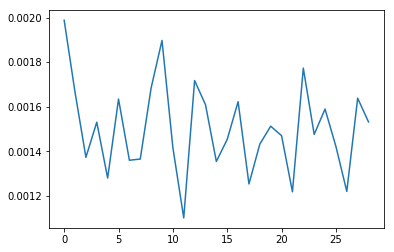

In [53]:
import matplotlib.pyplot as plt

plt.plot(losslist)
plt.show()

In [ ]:
orig, masked, _ = get_random_masked_batch(train, batch_size=1, p=0.5)

In [ ]:
(orig[0][:400] > 0).sum(), (masked[0][:400] > 0).sum()

In [ ]:
orig[0][:100]

In [ ]:
masked[0][:100]

In [ ]:
#-----------------Forward Pass----------------------
output = model(masked)

In [ ]:
((5*output[0]).round() >1).sum()

In [ ]:
(5*output).round()[0][2000:3000]

In [ ]:
orig, masked, _ = get_random_masked_batch(negative_feedback_mask, batch_size=1)

In [ ]:
orig[0][:400]

In [ ]:
masked[0][:400]

In [ ]:
#-----------------Forward Pass----------------------
output = model(masked)

In [ ]:
orig[0][:400](orig.round() > 0).sum()

In [ ]:
(masked.round() > 0).sum()

In [ ]:
(output.round() > 0).sum()

In [ ]:
output.round()[0,100:400]

In [ ]:
orig[0,100:400]

In [99]:
class conv_denoising_autoencoder(nn.Module):

    def __init__(self, inSize,fSize = 32, nz=24):  #sigma is the corruption level
        super(conv_denoising_autoencoder, self).__init__()
        #define layers here

        self.inp_size = inSize
        self.nz = nz
        self.fSize = 32
#         self.imSize = imSize
#         self.sigma = sigma
#         self.multimodalZ = multimodalZ

#         inSize = imSize / ( 2 ** 4)
#         self.inSize = inSize
    
        self.enc1 = nn.Conv1d(self.inp_size, fSize, 5, stride=2, padding=2)
        self.enc2 = nn.Conv1d(fSize, fSize * 2, 5, stride=2, padding=2)
        self.enc3 = nn.Conv1d(fSize * 2, fSize * 4, 5, stride=2, padding=2)
        self.enc4 = nn.Conv1d(fSize * 4, fSize * 8, 5, stride=2, padding=2)
        self.enc5 = nn.Linear(fSize * 8, self.nz)

        self.dec1 = nn.Linear(self.nz, fSize * 8)
        self.dec2 = nn.ConvTranspose1d(fSize * 8, fSize * 4, 3, stride=2, padding=1, output_padding=1)
        self.dec3 = nn.ConvTranspose1d(fSize * 4, fSize * 2, 3, stride=2, padding=1, output_padding=1)
        self.dec4 = nn.ConvTranspose1d(fSize * 2, fSize, 3, stride=2, padding=1, output_padding=1)
        self.dec5 = nn.ConvTranspose1d(fSize, 32, 3, stride=2, padding=1, output_padding=1)
        self.last_dec = nn.Linear(32*16, self.inp_size)
        
        self.useCUDA = torch.cuda.is_available()

#     def norm_prior(self, noSamples=25):
#         z = torch.randn(noSamples, self.nz)
#         return z

#     def multi_prior(self, noSamples=25, mode=None):
#         #make a 2D sqrt(nz)-by-sqrt(nz) grid of gaussians
#         num = np.sqrt(self.nz) #no of modes in x and y
#         STD = 1.0
#         modes = np.arange(-num,num)
#         p = np.random.uniform(0, num,(noSamples*2))

#         if mode is None:
#             mu = modes[np.floor(2 * p).astype(int)]
#         else:
#             mu = modes[np.ones((noSamples, 2), dtype=int) * int(mode)]

#         z = torch.Tensor(mu).view(-1,2) + STD * torch.randn(noSamples, 2)
#         return z

    def encode(self, x):
        self.batch_size = x.shape[0]
        #define the encoder here return mu(x) and sigma(x)
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        x = x.view(x.size(0), -1)
        x = self.enc5(x)

        return x

#     def corrupt(self, x):
#         noise = self.sigma * Variable(torch.randn(x.size())).type_as(x)
#         return x + noise

#     def sample_z(self, noSamples=25, mode=None):
#         if not self.multimodalZ:
#             z = self.norm_prior(noSamples=noSamples)
#         else:
#             z = self.multi_prior(noSamples=noSamples, mode=mode)
#         if self.useCUDA:
#             return Variable(z.cuda())
#         else:
#             return Variable(z)

    def decode(self, z):
        #define the decoder here
        z = F.relu(self.dec1(z))
        z = z.unsqueeze(2)
#         print(z.shape)
#         z = z.view(z.size(0), -1, self.inp_size)
        z = F.relu(self.dec2(z))
        z = F.relu(self.dec3(z))
        z = F.relu(self.dec4(z))
        z = F.sigmoid(self.dec5(z))
#         print(z.shape)
#         z = F.sigmoid(self.last_dec(z.view(self.batch_size, -1)))
        z = F.sigmoid(self.last_dec(z.view(self.batch_size, -1)))
    
        return z

    def forward(self, x):
        # the outputs needed for training
#         x_corr = self.corrupt(x)
        z = self.encode(x)
        return self.decode(z)

In [104]:
model = conv_denoising_autoencoder(train[0,:].shape[0]).to(device)
criterion = nn.MSELoss()
optimizer = optim.RMSprop(model.parameters(),lr=0.00005, weight_decay=1e-5)

In [105]:
steps_per_epoch = 500
train_den_ae(negative_feedback_mask, steps_per_epoch=steps_per_epoch, _unsqueeze=True)

Entering Epoch:  0
======> epoch: 0/400, Loss:0.2545660436153412
======> epoch: 0/400, Loss:0.13646429777145386
======> epoch: 0/400, Loss:0.10164164006710052
======> epoch: 0/400, Loss:0.0800740048289299
======> epoch: 0/400, Loss:0.067561075091362
======> epoch: 0/400, Loss:0.051747310906648636
======> epoch: 0/400, Loss:0.049292780458927155
======> epoch: 0/400, Loss:0.04357948899269104
======> epoch: 0/400, Loss:0.039391905069351196
======> epoch: 0/400, Loss:0.03379664197564125
Entering Epoch:  1
======> epoch: 1/400, Loss:0.03003634139895439
======> epoch: 1/400, Loss:0.029221657663583755
======> epoch: 1/400, Loss:0.025732366368174553
======> epoch: 1/400, Loss:0.024505173787474632
======> epoch: 1/400, Loss:0.019951054826378822
======> epoch: 1/400, Loss:0.020588405430316925
======> epoch: 1/400, Loss:0.018274320289492607
======> epoch: 1/400, Loss:0.015971334651112556
======> epoch: 1/400, Loss:0.017909860238432884
======> epoch: 1/400, Loss:0.01941029541194439
Entering Epoch:

======> epoch: 16/400, Loss:0.019934987649321556
======> epoch: 16/400, Loss:0.009844097308814526
======> epoch: 16/400, Loss:0.009207694791257381
======> epoch: 16/400, Loss:0.014683552086353302
======> epoch: 16/400, Loss:0.015019706450402737
======> epoch: 16/400, Loss:0.014550572261214256
======> epoch: 16/400, Loss:0.015612130984663963
Entering Epoch:  17
======> epoch: 17/400, Loss:0.019266869872808456
======> epoch: 17/400, Loss:0.01314553152769804
======> epoch: 17/400, Loss:0.010828066617250443
======> epoch: 17/400, Loss:0.01685967668890953
======> epoch: 17/400, Loss:0.01370555255562067
======> epoch: 17/400, Loss:0.015810344368219376
======> epoch: 17/400, Loss:0.02044501155614853
======> epoch: 17/400, Loss:0.011476344428956509
======> epoch: 17/400, Loss:0.016443194821476936
======> epoch: 17/400, Loss:0.01229130383580923
Entering Epoch:  18
======> epoch: 18/400, Loss:0.019331572577357292
======> epoch: 18/400, Loss:0.015647921711206436
======> epoch: 18/400, Loss:0.0180

======> epoch: 32/400, Loss:0.012725458480417728
======> epoch: 32/400, Loss:0.020167164504528046
======> epoch: 32/400, Loss:0.015536360442638397
======> epoch: 32/400, Loss:0.017880691215395927
======> epoch: 32/400, Loss:0.01674119010567665
======> epoch: 32/400, Loss:0.01448989287018776
Entering Epoch:  33
======> epoch: 33/400, Loss:0.0167999267578125
======> epoch: 33/400, Loss:0.018233058974146843
======> epoch: 33/400, Loss:0.015108196064829826
======> epoch: 33/400, Loss:0.016840750351548195
======> epoch: 33/400, Loss:0.013519197702407837
======> epoch: 33/400, Loss:0.014028675854206085
======> epoch: 33/400, Loss:0.010486879386007786
======> epoch: 33/400, Loss:0.015779167413711548
======> epoch: 33/400, Loss:0.013879083096981049
======> epoch: 33/400, Loss:0.021043838933110237
Entering Epoch:  34
======> epoch: 34/400, Loss:0.012593003921210766
======> epoch: 34/400, Loss:0.015538944862782955
======> epoch: 34/400, Loss:0.015081541612744331
======> epoch: 34/400, Loss:0.015

======> epoch: 48/400, Loss:0.014989576302468777
======> epoch: 48/400, Loss:0.01396362204104662
======> epoch: 48/400, Loss:0.012395970523357391
======> epoch: 48/400, Loss:0.01517759170383215
======> epoch: 48/400, Loss:0.01569855771958828
Entering Epoch:  49
======> epoch: 49/400, Loss:0.016399597749114037
======> epoch: 49/400, Loss:0.018661433830857277
======> epoch: 49/400, Loss:0.015002459287643433
======> epoch: 49/400, Loss:0.016290025785565376
======> epoch: 49/400, Loss:0.019028980284929276
======> epoch: 49/400, Loss:0.01088008377701044
======> epoch: 49/400, Loss:0.01150442659854889
======> epoch: 49/400, Loss:0.022196371108293533
======> epoch: 49/400, Loss:0.010938665829598904
======> epoch: 49/400, Loss:0.013481821864843369
Entering Epoch:  50
======> epoch: 50/400, Loss:0.015873152762651443
======> epoch: 50/400, Loss:0.018292425200343132
======> epoch: 50/400, Loss:0.013059820979833603
======> epoch: 50/400, Loss:0.015393165871500969
======> epoch: 50/400, Loss:0.0159

======> epoch: 64/400, Loss:0.012891707010567188
======> epoch: 64/400, Loss:0.012891062535345554
======> epoch: 64/400, Loss:0.020768960937857628
======> epoch: 64/400, Loss:0.012819095514714718
Entering Epoch:  65
======> epoch: 65/400, Loss:0.013138984329998493
======> epoch: 65/400, Loss:0.015568649396300316
======> epoch: 65/400, Loss:0.013120357878506184
======> epoch: 65/400, Loss:0.017046932131052017
======> epoch: 65/400, Loss:0.015837032347917557
======> epoch: 65/400, Loss:0.016536341980099678
======> epoch: 65/400, Loss:0.012481722980737686
======> epoch: 65/400, Loss:0.014924466609954834
======> epoch: 65/400, Loss:0.014447258785367012
======> epoch: 65/400, Loss:0.011063400655984879
Entering Epoch:  66
======> epoch: 66/400, Loss:0.014381572604179382
======> epoch: 66/400, Loss:0.014970212243497372
======> epoch: 66/400, Loss:0.009985006414353848
======> epoch: 66/400, Loss:0.015938905999064445
======> epoch: 66/400, Loss:0.016173942014575005
======> epoch: 66/400, Loss:0

======> epoch: 80/400, Loss:0.014705264940857887
======> epoch: 80/400, Loss:0.014005033299326897
======> epoch: 80/400, Loss:0.01963426172733307
Entering Epoch:  81
======> epoch: 81/400, Loss:0.017675019800662994
======> epoch: 81/400, Loss:0.014776811003684998
======> epoch: 81/400, Loss:0.020547637715935707
======> epoch: 81/400, Loss:0.014989279210567474
======> epoch: 81/400, Loss:0.014867104589939117
======> epoch: 81/400, Loss:0.013735237531363964
======> epoch: 81/400, Loss:0.014152862131595612
======> epoch: 81/400, Loss:0.015568039380013943
======> epoch: 81/400, Loss:0.013131240382790565
======> epoch: 81/400, Loss:0.01424360927194357
Entering Epoch:  82
======> epoch: 82/400, Loss:0.012060108594596386
======> epoch: 82/400, Loss:0.01636597141623497
======> epoch: 82/400, Loss:0.0154776182025671
======> epoch: 82/400, Loss:0.015750255435705185
======> epoch: 82/400, Loss:0.01393483579158783
======> epoch: 82/400, Loss:0.01456539984792471
======> epoch: 82/400, Loss:0.013018

======> epoch: 96/400, Loss:0.01275708433240652
======> epoch: 96/400, Loss:0.014708688482642174
Entering Epoch:  97
======> epoch: 97/400, Loss:0.015254855155944824
======> epoch: 97/400, Loss:0.01984199695289135
======> epoch: 97/400, Loss:0.017509164288640022
======> epoch: 97/400, Loss:0.017432764172554016
======> epoch: 97/400, Loss:0.020419923588633537
======> epoch: 97/400, Loss:0.014604361727833748
======> epoch: 97/400, Loss:0.01669328659772873
======> epoch: 97/400, Loss:0.010570451617240906
======> epoch: 97/400, Loss:0.015910843387246132
======> epoch: 97/400, Loss:0.01405369583517313
Entering Epoch:  98
======> epoch: 98/400, Loss:0.013195951469242573
======> epoch: 98/400, Loss:0.01737936958670616
======> epoch: 98/400, Loss:0.010853279381990433
======> epoch: 98/400, Loss:0.01649463176727295
======> epoch: 98/400, Loss:0.02031892165541649
======> epoch: 98/400, Loss:0.014961514621973038
======> epoch: 98/400, Loss:0.012947230599820614
======> epoch: 98/400, Loss:0.015703

======> epoch: 112/400, Loss:0.016834765672683716
======> epoch: 112/400, Loss:0.01826358027756214
======> epoch: 112/400, Loss:0.014087523333728313
======> epoch: 112/400, Loss:0.01837659440934658
Entering Epoch:  113
======> epoch: 113/400, Loss:0.013751021586358547
======> epoch: 113/400, Loss:0.01335174310952425
======> epoch: 113/400, Loss:0.01664269156754017
======> epoch: 113/400, Loss:0.013931103982031345
======> epoch: 113/400, Loss:0.01667972467839718
======> epoch: 113/400, Loss:0.016447391360998154
======> epoch: 113/400, Loss:0.02141483686864376
======> epoch: 113/400, Loss:0.013387735933065414
======> epoch: 113/400, Loss:0.01404977310448885
======> epoch: 113/400, Loss:0.01584848016500473
Entering Epoch:  114
======> epoch: 114/400, Loss:0.014394557103514671
======> epoch: 114/400, Loss:0.01216218527406454
======> epoch: 114/400, Loss:0.013987651094794273
======> epoch: 114/400, Loss:0.020021561533212662
======> epoch: 114/400, Loss:0.019446469843387604
======> epoch: 11

======> epoch: 128/400, Loss:0.013290327042341232
======> epoch: 128/400, Loss:0.015859493985772133
======> epoch: 128/400, Loss:0.016322653740644455
======> epoch: 128/400, Loss:0.017565933987498283
======> epoch: 128/400, Loss:0.015402313321828842
======> epoch: 128/400, Loss:0.01255701296031475
Entering Epoch:  129
======> epoch: 129/400, Loss:0.016313595697283745
======> epoch: 129/400, Loss:0.023338409140706062
======> epoch: 129/400, Loss:0.014691623859107494
======> epoch: 129/400, Loss:0.015193527564406395
======> epoch: 129/400, Loss:0.01925238035619259
======> epoch: 129/400, Loss:0.013819344341754913
======> epoch: 129/400, Loss:0.014481490477919579
======> epoch: 129/400, Loss:0.014820006676018238
======> epoch: 129/400, Loss:0.014776994474232197
======> epoch: 129/400, Loss:0.012868017889559269
Entering Epoch:  130
======> epoch: 130/400, Loss:0.014333445578813553
======> epoch: 130/400, Loss:0.015504339709877968
======> epoch: 130/400, Loss:0.014060525223612785
======> ep

======> epoch: 144/400, Loss:0.01615094766020775
======> epoch: 144/400, Loss:0.014571242034435272
======> epoch: 144/400, Loss:0.01563005894422531
======> epoch: 144/400, Loss:0.015498456545174122
======> epoch: 144/400, Loss:0.015003793872892857
======> epoch: 144/400, Loss:0.015361753292381763
======> epoch: 144/400, Loss:0.018381105735898018
======> epoch: 144/400, Loss:0.018223127350211143
======> epoch: 144/400, Loss:0.014746738597750664
Entering Epoch:  145
======> epoch: 145/400, Loss:0.009765777736902237
======> epoch: 145/400, Loss:0.016078993678092957
======> epoch: 145/400, Loss:0.011225122027099133
======> epoch: 145/400, Loss:0.015359537675976753
======> epoch: 145/400, Loss:0.013526396825909615
======> epoch: 145/400, Loss:0.015165743418037891
======> epoch: 145/400, Loss:0.015621554106473923
======> epoch: 145/400, Loss:0.013247659429907799
======> epoch: 145/400, Loss:0.015119788236916065
======> epoch: 145/400, Loss:0.014508781023323536
Entering Epoch:  146
======> ep

======> epoch: 159/400, Loss:0.014762538485229015
Entering Epoch:  160
======> epoch: 160/400, Loss:0.013859348371624947
======> epoch: 160/400, Loss:0.01652977243065834
======> epoch: 160/400, Loss:0.014855874702334404
======> epoch: 160/400, Loss:0.020174283534288406
======> epoch: 160/400, Loss:0.01232251338660717
======> epoch: 160/400, Loss:0.016468746587634087
======> epoch: 160/400, Loss:0.018383000046014786
======> epoch: 160/400, Loss:0.016566189005970955
======> epoch: 160/400, Loss:0.018143346533179283
======> epoch: 160/400, Loss:0.01286672055721283
Entering Epoch:  161
======> epoch: 161/400, Loss:0.018289735540747643
======> epoch: 161/400, Loss:0.013705185614526272
======> epoch: 161/400, Loss:0.018939275294542313
======> epoch: 161/400, Loss:0.014629460871219635
======> epoch: 161/400, Loss:0.016506226733326912
======> epoch: 161/400, Loss:0.014369134791195393
======> epoch: 161/400, Loss:0.016102775931358337
======> epoch: 161/400, Loss:0.01862928457558155
======> epoc

======> epoch: 175/400, Loss:0.021975109353661537
======> epoch: 175/400, Loss:0.012056829407811165
======> epoch: 175/400, Loss:0.012197857722640038
======> epoch: 175/400, Loss:0.014509650878608227
Entering Epoch:  176
======> epoch: 176/400, Loss:0.01335200946778059
======> epoch: 176/400, Loss:0.013901520520448685
======> epoch: 176/400, Loss:0.012151484377682209
======> epoch: 176/400, Loss:0.014368348754942417
======> epoch: 176/400, Loss:0.01696890965104103
======> epoch: 176/400, Loss:0.0102365892380476
======> epoch: 176/400, Loss:0.012554853223264217
======> epoch: 176/400, Loss:0.019336452707648277
======> epoch: 176/400, Loss:0.017042504623532295
======> epoch: 176/400, Loss:0.014267822727560997
Entering Epoch:  177
======> epoch: 177/400, Loss:0.01637381874024868
======> epoch: 177/400, Loss:0.01540965586900711
======> epoch: 177/400, Loss:0.013781423680484295
======> epoch: 177/400, Loss:0.01553295087069273
======> epoch: 177/400, Loss:0.014868992380797863
======> epoch: 

======> epoch: 191/400, Loss:0.014843015931546688
======> epoch: 191/400, Loss:0.017843516543507576
======> epoch: 191/400, Loss:0.014125745743513107
======> epoch: 191/400, Loss:0.012219337746500969
======> epoch: 191/400, Loss:0.013920974917709827
======> epoch: 191/400, Loss:0.016130248084664345
Entering Epoch:  192
======> epoch: 192/400, Loss:0.021976955235004425
======> epoch: 192/400, Loss:0.014475475065410137
======> epoch: 192/400, Loss:0.013158842921257019
======> epoch: 192/400, Loss:0.013597664423286915
======> epoch: 192/400, Loss:0.014711719006299973
======> epoch: 192/400, Loss:0.013023888692259789
======> epoch: 192/400, Loss:0.013752728700637817
======> epoch: 192/400, Loss:0.012819857336580753
======> epoch: 192/400, Loss:0.013256671838462353
======> epoch: 192/400, Loss:0.01642780378460884
Entering Epoch:  193
======> epoch: 193/400, Loss:0.011025889776647091
======> epoch: 193/400, Loss:0.01428842544555664
======> epoch: 193/400, Loss:0.021424055099487305
======> ep

======> epoch: 207/400, Loss:0.01739540323615074
======> epoch: 207/400, Loss:0.015908988192677498
======> epoch: 207/400, Loss:0.01526040118187666
======> epoch: 207/400, Loss:0.01628059148788452
======> epoch: 207/400, Loss:0.017653068527579308
======> epoch: 207/400, Loss:0.01390737947076559
======> epoch: 207/400, Loss:0.011607391759753227
======> epoch: 207/400, Loss:0.014678307808935642
======> epoch: 207/400, Loss:0.012589902617037296
Entering Epoch:  208
======> epoch: 208/400, Loss:0.01701158843934536
======> epoch: 208/400, Loss:0.017383191734552383
======> epoch: 208/400, Loss:0.010226186364889145
======> epoch: 208/400, Loss:0.01838976889848709
======> epoch: 208/400, Loss:0.01841737888753414
======> epoch: 208/400, Loss:0.011104036122560501
======> epoch: 208/400, Loss:0.014023097231984138
======> epoch: 208/400, Loss:0.014950999058783054
======> epoch: 208/400, Loss:0.014132067561149597
======> epoch: 208/400, Loss:0.014585531316697598
Entering Epoch:  209
======> epoch: 

======> epoch: 222/400, Loss:0.014538684859871864
Entering Epoch:  223
======> epoch: 223/400, Loss:0.01807417906820774
======> epoch: 223/400, Loss:0.01698041521012783
======> epoch: 223/400, Loss:0.01679515466094017
======> epoch: 223/400, Loss:0.015925398096442223
======> epoch: 223/400, Loss:0.011290233582258224
======> epoch: 223/400, Loss:0.019222700968384743
======> epoch: 223/400, Loss:0.015181842260062695
======> epoch: 223/400, Loss:0.01814492605626583
======> epoch: 223/400, Loss:0.020112082362174988
======> epoch: 223/400, Loss:0.0155952712520957
Entering Epoch:  224
======> epoch: 224/400, Loss:0.017727535218000412
======> epoch: 224/400, Loss:0.015594763681292534
======> epoch: 224/400, Loss:0.016363805159926414
======> epoch: 224/400, Loss:0.014757721684873104
======> epoch: 224/400, Loss:0.01676582358777523
======> epoch: 224/400, Loss:0.01755339466035366
======> epoch: 224/400, Loss:0.01285669393837452
======> epoch: 224/400, Loss:0.01366361603140831
======> epoch: 224

======> epoch: 238/400, Loss:0.021553609520196915
======> epoch: 238/400, Loss:0.012818541377782822
======> epoch: 238/400, Loss:0.013928461819887161
Entering Epoch:  239
======> epoch: 239/400, Loss:0.012604939751327038
======> epoch: 239/400, Loss:0.014761186204850674
======> epoch: 239/400, Loss:0.016260463744401932
======> epoch: 239/400, Loss:0.019260745495557785
======> epoch: 239/400, Loss:0.015341871418058872
======> epoch: 239/400, Loss:0.012477440759539604
======> epoch: 239/400, Loss:0.011015810072422028
======> epoch: 239/400, Loss:0.016727209091186523
======> epoch: 239/400, Loss:0.013963247649371624
======> epoch: 239/400, Loss:0.014400990679860115
Entering Epoch:  240
======> epoch: 240/400, Loss:0.017254021018743515
======> epoch: 240/400, Loss:0.016387218609452248
======> epoch: 240/400, Loss:0.016177581623196602
======> epoch: 240/400, Loss:0.016467029228806496
======> epoch: 240/400, Loss:0.013651895336806774
======> epoch: 240/400, Loss:0.013059047050774097
======> 

======> epoch: 254/400, Loss:0.014316460117697716
======> epoch: 254/400, Loss:0.01700325682759285
======> epoch: 254/400, Loss:0.016870509833097458
======> epoch: 254/400, Loss:0.015243113972246647
======> epoch: 254/400, Loss:0.015804503113031387
Entering Epoch:  255
======> epoch: 255/400, Loss:0.01721973344683647
======> epoch: 255/400, Loss:0.012476478703320026
======> epoch: 255/400, Loss:0.01183521468192339
======> epoch: 255/400, Loss:0.016258547082543373
======> epoch: 255/400, Loss:0.014170272275805473
======> epoch: 255/400, Loss:0.015573552809655666
======> epoch: 255/400, Loss:0.015484794974327087
======> epoch: 255/400, Loss:0.01747635379433632
======> epoch: 255/400, Loss:0.014926353469491005
======> epoch: 255/400, Loss:0.011353861540555954
Entering Epoch:  256
======> epoch: 256/400, Loss:0.013742855750024319
======> epoch: 256/400, Loss:0.014860059134662151
======> epoch: 256/400, Loss:0.011798963882029057
======> epoch: 256/400, Loss:0.016087418422102928
======> epoc

======> epoch: 270/400, Loss:0.011910932138562202
======> epoch: 270/400, Loss:0.019241774454712868
======> epoch: 270/400, Loss:0.0114822369068861
======> epoch: 270/400, Loss:0.013109592720866203
======> epoch: 270/400, Loss:0.015712270513176918
======> epoch: 270/400, Loss:0.012931585311889648
======> epoch: 270/400, Loss:0.018814118579030037
======> epoch: 270/400, Loss:0.017468338832259178
Entering Epoch:  271
======> epoch: 271/400, Loss:0.01902139000594616
======> epoch: 271/400, Loss:0.013091079890727997
======> epoch: 271/400, Loss:0.013500732369720936
======> epoch: 271/400, Loss:0.011319753713905811
======> epoch: 271/400, Loss:0.012000003829598427
======> epoch: 271/400, Loss:0.015568665228784084
======> epoch: 271/400, Loss:0.012924807146191597
======> epoch: 271/400, Loss:0.018830597400665283
======> epoch: 271/400, Loss:0.016671158373355865
======> epoch: 271/400, Loss:0.013866133987903595
Entering Epoch:  272
======> epoch: 272/400, Loss:0.01607646234333515
======> epoc

Entering Epoch:  286
======> epoch: 286/400, Loss:0.013172382488846779
======> epoch: 286/400, Loss:0.015820812433958054
======> epoch: 286/400, Loss:0.013348130509257317
======> epoch: 286/400, Loss:0.015590869821608067
======> epoch: 286/400, Loss:0.016666671261191368
======> epoch: 286/400, Loss:0.013271678239107132
======> epoch: 286/400, Loss:0.015675481408834457
======> epoch: 286/400, Loss:0.015977058559656143
======> epoch: 286/400, Loss:0.012139699421823025
======> epoch: 286/400, Loss:0.017142003402113914
Entering Epoch:  287
======> epoch: 287/400, Loss:0.011750562116503716
======> epoch: 287/400, Loss:0.014344770461320877
======> epoch: 287/400, Loss:0.009268532507121563
======> epoch: 287/400, Loss:0.015578082762658596
======> epoch: 287/400, Loss:0.014653396792709827
======> epoch: 287/400, Loss:0.017175132408738136
======> epoch: 287/400, Loss:0.015043512918055058
======> epoch: 287/400, Loss:0.012818612158298492
======> epoch: 287/400, Loss:0.015192229300737381
======> 

======> epoch: 301/400, Loss:0.01902330107986927
======> epoch: 301/400, Loss:0.017204048112034798
======> epoch: 301/400, Loss:0.017359841614961624
Entering Epoch:  302
======> epoch: 302/400, Loss:0.009368015453219414
======> epoch: 302/400, Loss:0.015292119234800339
======> epoch: 302/400, Loss:0.013390201143920422
======> epoch: 302/400, Loss:0.01681150682270527
======> epoch: 302/400, Loss:0.017050135880708694
======> epoch: 302/400, Loss:0.01159864291548729
======> epoch: 302/400, Loss:0.0166162196546793
======> epoch: 302/400, Loss:0.01775604858994484
======> epoch: 302/400, Loss:0.017874933779239655
======> epoch: 302/400, Loss:0.014174750074744225
Entering Epoch:  303
======> epoch: 303/400, Loss:0.017198899760842323
======> epoch: 303/400, Loss:0.017385784536600113
======> epoch: 303/400, Loss:0.01822422817349434
======> epoch: 303/400, Loss:0.017144199460744858
======> epoch: 303/400, Loss:0.017336362972855568
======> epoch: 303/400, Loss:0.013524627313017845
======> epoch: 

======> epoch: 317/400, Loss:0.015170630998909473
======> epoch: 317/400, Loss:0.012884305790066719
======> epoch: 317/400, Loss:0.016439078375697136
======> epoch: 317/400, Loss:0.015754692256450653
======> epoch: 317/400, Loss:0.017256207764148712
Entering Epoch:  318
======> epoch: 318/400, Loss:0.015773937106132507
======> epoch: 318/400, Loss:0.01280815340578556
======> epoch: 318/400, Loss:0.016297364607453346
======> epoch: 318/400, Loss:0.012432792223989964
======> epoch: 318/400, Loss:0.014945107512176037
======> epoch: 318/400, Loss:0.017538709565997124
======> epoch: 318/400, Loss:0.01847555674612522
======> epoch: 318/400, Loss:0.015953456982970238
======> epoch: 318/400, Loss:0.010899831540882587
======> epoch: 318/400, Loss:0.01539685856550932
Entering Epoch:  319
======> epoch: 319/400, Loss:0.01648966409265995
======> epoch: 319/400, Loss:0.014369926415383816
======> epoch: 319/400, Loss:0.020627494901418686
======> epoch: 319/400, Loss:0.013783028349280357
======> epoc

======> epoch: 333/400, Loss:0.02073114737868309
======> epoch: 333/400, Loss:0.014076965861022472
======> epoch: 333/400, Loss:0.018633294850587845
======> epoch: 333/400, Loss:0.015352314338088036
======> epoch: 333/400, Loss:0.013968104496598244
======> epoch: 333/400, Loss:0.015494550578296185
======> epoch: 333/400, Loss:0.019007490947842598
======> epoch: 333/400, Loss:0.013059938326478004
Entering Epoch:  334
======> epoch: 334/400, Loss:0.009976765140891075
======> epoch: 334/400, Loss:0.0177010390907526
======> epoch: 334/400, Loss:0.013269300572574139
======> epoch: 334/400, Loss:0.014569570310413837
======> epoch: 334/400, Loss:0.015982745215296745
======> epoch: 334/400, Loss:0.013583403080701828
======> epoch: 334/400, Loss:0.01182128768414259
======> epoch: 334/400, Loss:0.016301767900586128
======> epoch: 334/400, Loss:0.015025279484689236
======> epoch: 334/400, Loss:0.014870686456561089
Entering Epoch:  335
======> epoch: 335/400, Loss:0.015165647491812706
======> epoc

Entering Epoch:  349
======> epoch: 349/400, Loss:0.014988197013735771
======> epoch: 349/400, Loss:0.01717808097600937
======> epoch: 349/400, Loss:0.01608947291970253
======> epoch: 349/400, Loss:0.013332986272871494
======> epoch: 349/400, Loss:0.01696423999965191
======> epoch: 349/400, Loss:0.015873147174715996
======> epoch: 349/400, Loss:0.013218123465776443
======> epoch: 349/400, Loss:0.011544350534677505
======> epoch: 349/400, Loss:0.018576525151729584
======> epoch: 349/400, Loss:0.013730855658650398
Entering Epoch:  350
======> epoch: 350/400, Loss:0.01669742539525032
======> epoch: 350/400, Loss:0.011870189569890499
======> epoch: 350/400, Loss:0.016718270257115364
======> epoch: 350/400, Loss:0.015927597880363464
======> epoch: 350/400, Loss:0.01792927458882332
======> epoch: 350/400, Loss:0.00876150093972683
======> epoch: 350/400, Loss:0.018593501299619675
======> epoch: 350/400, Loss:0.020582256838679314
======> epoch: 350/400, Loss:0.014288206584751606
======> epoch:

======> epoch: 364/400, Loss:0.020183775573968887
======> epoch: 364/400, Loss:0.01392377633601427
Entering Epoch:  365
======> epoch: 365/400, Loss:0.0115343714132905
======> epoch: 365/400, Loss:0.019078442826867104
======> epoch: 365/400, Loss:0.013583892956376076
======> epoch: 365/400, Loss:0.012984607368707657
======> epoch: 365/400, Loss:0.014722192659974098
======> epoch: 365/400, Loss:0.015302681364119053
======> epoch: 365/400, Loss:0.013093821704387665
======> epoch: 365/400, Loss:0.010808825492858887
======> epoch: 365/400, Loss:0.014542685821652412
======> epoch: 365/400, Loss:0.015571814961731434
Entering Epoch:  366
======> epoch: 366/400, Loss:0.01274961419403553
======> epoch: 366/400, Loss:0.009430072270333767
======> epoch: 366/400, Loss:0.01806306652724743
======> epoch: 366/400, Loss:0.017613690346479416
======> epoch: 366/400, Loss:0.011605150997638702
======> epoch: 366/400, Loss:0.014897882007062435
======> epoch: 366/400, Loss:0.014959053136408329
======> epoch

======> epoch: 380/400, Loss:0.012584468349814415
======> epoch: 380/400, Loss:0.015110705979168415
======> epoch: 380/400, Loss:0.014236112125217915
======> epoch: 380/400, Loss:0.0193990096449852
======> epoch: 380/400, Loss:0.012285381555557251
Entering Epoch:  381
======> epoch: 381/400, Loss:0.019871024414896965
======> epoch: 381/400, Loss:0.016707414761185646
======> epoch: 381/400, Loss:0.013554313220083714
======> epoch: 381/400, Loss:0.019448071718215942
======> epoch: 381/400, Loss:0.014483476988971233
======> epoch: 381/400, Loss:0.017926832661032677
======> epoch: 381/400, Loss:0.01430247351527214
======> epoch: 381/400, Loss:0.013769233599305153
======> epoch: 381/400, Loss:0.01529011968523264
======> epoch: 381/400, Loss:0.014028453268110752
Entering Epoch:  382
======> epoch: 382/400, Loss:0.015102464705705643
======> epoch: 382/400, Loss:0.016942167654633522
======> epoch: 382/400, Loss:0.008700931444764137
======> epoch: 382/400, Loss:0.015225795097649097
======> epoc

======> epoch: 396/400, Loss:0.014506584033370018
======> epoch: 396/400, Loss:0.0126028535887599
======> epoch: 396/400, Loss:0.010675007477402687
======> epoch: 396/400, Loss:0.016333511099219322
======> epoch: 396/400, Loss:0.020815875381231308
======> epoch: 396/400, Loss:0.010773994028568268
======> epoch: 396/400, Loss:0.01608465239405632
======> epoch: 396/400, Loss:0.016604388132691383
Entering Epoch:  397
======> epoch: 397/400, Loss:0.01672661118209362
======> epoch: 397/400, Loss:0.010870153084397316
======> epoch: 397/400, Loss:0.018910042941570282
======> epoch: 397/400, Loss:0.019033309072256088
======> epoch: 397/400, Loss:0.01262848824262619
======> epoch: 397/400, Loss:0.01100054383277893
======> epoch: 397/400, Loss:0.013537947088479996
======> epoch: 397/400, Loss:0.013217879459261894
======> epoch: 397/400, Loss:0.016710994765162468
======> epoch: 397/400, Loss:0.02014409750699997
Entering Epoch:  398
======> epoch: 398/400, Loss:0.014190933667123318
======> epoch: 

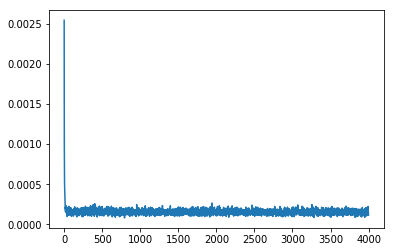

In [106]:
import matplotlib.pyplot as plt

plt.plot(losslist)
plt.show()

In [147]:
orig, masked, _ = get_random_masked_batch(negative_feedback_mask, batch_size=64)

In [148]:
(orig[0][:400] > 0).sum(), (masked[0][:400] > 0).sum()

(tensor(27, device='cuda:0'), tensor(12, device='cuda:0'))

In [149]:
orig[0][:400]

tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 1., 

In [150]:
masked[0][:400]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 

In [151]:
#-----------------Forward Pass----------------------
output = model(masked.unsqueeze(2))

In [152]:
output.shape

torch.Size([64, 3706])

In [153]:
((output[0]).round() >0).sum()

tensor(0, device='cuda:0')

In [156]:
((output).round() >= 1 ).sum()

tensor(139, device='cuda:0')

In [154]:
(output).round()[0][2000:3000]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [94]:
(output > 0.5).sum()

tensor(0, device='cuda:0')

In [ ]:
!git clone https://github.com/gtshs2/Collaborative-Denoising-Auto-Encoder

In [ ]:
((tr + vr) > 0).sum()

In [ ]:
!mkdir Collaborative-Denoising-Auto-Encoder/data